# Regularized Least Squares

Regularization introduces to an optimization problem prior information
or assumptions about properties of an optimal solution. A regularization
parameter governs the tradeoff between the fidelity to the unmodified
problem and the desired solution properties.


In [4]:
import Pkg;
Pkg.add("Convex")
Pkg.add("ECOS")
Pkg.add("Random")

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
   Installed CEnum ──── v0.5.0
   Installed ECOS_jll ─ v200.0.800+0
   Installed ECOS ───── v1.1.3
  Installing 1 artifacts
   Installed artifact ECOS                  91.6 KiB
    Updating `~/.julia/environments/v1.12/Project.toml`
  [e2685f51] + ECOS v1.1.3
    Updating `~/.julia/environments/v1.12/Manifest.toml`
  [fa961155] + CEnum v0.5.0
  [e2685f51] + ECOS v1.1.3
  [c2c64177] + ECOS_jll v200.0.800+0
Precompiling packages...
   1647.9 ms  ✓ ECOS_jll
   2167.7 ms  ✓ CEnum
   4629.2 ms  ✓ ECOS
  3 dependencies successfully precompiled in 7 seconds. 310 already precompiled.
   Resolving package versions...
    Updating `~/.julia/environments/v1.12/Project.toml`
  [9a3f8284] + Random v1.11.0
    Manifest No packages added to or removed 

In [5]:
# Packages for this notebook
using Random; Random.seed!(1234)
using Convex, ECOS, LinearAlgebra, Plots

## The Pareto Frontier

The standard least-squares problem can be interpreted as a method for recovering some underlying object (such as a signal or image) encoded in the vector $x_0$ using noisy measurements of the form:

$$ 
b := Ax_0 + \eta \tag{1}
$$

where $\eta$ is random additive error in the observations $b$ and the matrix $A$ describes the measurement process. The least-squares problem:

$$
\min_{x \in \mathbb{R}^n} \|Ax - b\|^2
$$

seeks a solution $x$ under the implicit assumption that the noise term $\eta$ is small.

### Competing Objectives
But what if $x$ also needs to satisfy some other competing objective? Suppose, for example, that we also have available another set of measurements of $x_0$ of the form $d = Cx_0 + w$, where $w$ is also a random error. The "best" choice for $x$ is not necessarily found by solving Equation 1; instead, we wish to choose $x$ to balance the two objective function values:

$$
f_1(x) \quad \text{and} \quad f_2(x) \tag{2}
$$

Generally, we can make $f_1(x)$ or $f_2(x)$ small, but not both. Figure 1 sketches the relationship between the pair $\xi(x) := \{f_1(x), f_2(x)\}$.



> **Figure 1: The Pareto frontier.** The points $\xi^{(i)} := (f_1(x^{(i)}), f_2(x^{(i)}))$ correspond to a solution $x^{(i)}$ of the weighted problem in Equation 2. The area above the curve is possibly realizable for some $x$; the points below the curve are not achievable by *any* $x$.

The objective pairs on the boundary of these two regions is the [Pareto frontier](https://en.wikipedia.org/wiki/Pareto_efficiency). We can compute these Pareto optimal solutions $x$ by solving the optimization problem:

$$ 
\min_x \{ \alpha_1 f_1(x) + \alpha_2 f_2(x) \} \tag{3}
$$

where the pair of positive **penalty parameters** $(\alpha_1, \alpha_2)$ provides the relative weight between the objectives. 

For fixed penalties $\alpha_1$ and $\alpha_2$, the set:

$$
\{ (f_1(x), f_2(x)) \mid \alpha_1 f_1(x) + \alpha_2 f_2(x) = \alpha, x \in \mathbb{R}^n \}
$$

forms the graph of a line with a slope of $-(\alpha_1 / \alpha_2)$. We may visualize the optimization problem in Equation 3 as the problem of finding the smallest value $\alpha$ such that the line is tangent to the Pareto frontier, as shown in Figure 1.

---

## Tikhonov Regularization

A particularly common example of regularized least-squares is [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), which has the form:

$$
\min_{x} \frac{1}{2}\|Ax - b\|^2 + \frac{\lambda}{2}\|Dx\|^2
$$

This objective can be expressed equivalently as:

$$
\|Ax - b\|^2 + \lambda\|Dx\|^2 = \left\| \begin{bmatrix} A \\ \sqrt{\lambda}D \end{bmatrix} x - \begin{bmatrix} b \\ 0 \end{bmatrix} \right\|^2
$$

If $D$ has full column rank, then the stacked matrix $\begin{bmatrix} A \\ \sqrt{\lambda}D \end{bmatrix}$ necessarily also has full rank for any positive $\lambda$, which implies that the regularized problem always has a **well-defined unique solution**.

---

## Example: Signal Denoising

Consider a noisy measurement:

$$
b := x^\natural + \eta
$$

of a signal $x^\natural$, where the vector $\eta$ represents unknown noise, say, due to measurement error. Here’s a simple 1-dimensional noisy signal:

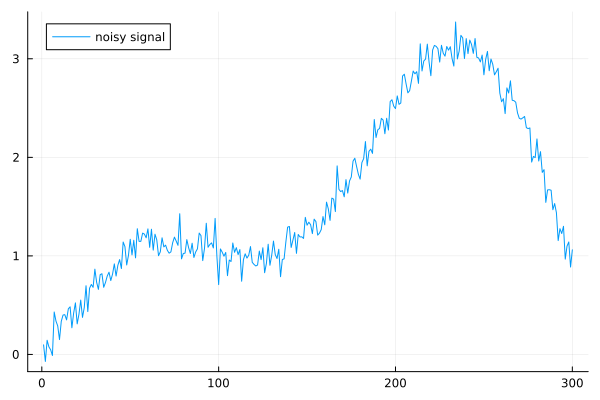

In [6]:
n = 300
t = LinRange(0, 4, n)
x = @. sin(t) + t*cos(t)^2
w = 0.1*randn(n)
b = x + w
plot(b, leg=:topleft, label="noisy signal")

## Signal Denoising and Smoothness

The obvious least-squares problem

$$
\min_{x} \frac{1}{2}\|x-b\|^2
$$

isn’t useful because the optimal solution is simply the noisy measurements $b$, and so it doesn’t yield any new information. But suppose we believe that the signal is "smooth" in the sense that the consecutive elements of the vector $x=(x_1, \dots, x_n)$ change relatively little, i.e., the difference $|x_i - x_{i+1}|$ is small relative to $x$.

In this case, we might balance the least-squares fit against the smoothness of the solution by instead solving the regularized least-squares problem:

$$
\min_{x} \frac{1}{2}\underbrace{\|x-b\|^2}_{f_1(x)} + \lambda \frac{1}{2} \underbrace{\sum_{i=1}^{n-1}(x_i - x_{i+1})^2}_{f_2(x)} \tag{5}
$$

The role of the regularizer $f_2(x)$ is to promote smooth changes in the elements of $x$.



---

### Matrix Notation

We can alternatively write the above minimization program in matrix notation. Define the $(n-1) \times n$ **finite difference matrix** $D$:

$$
D = \begin{bmatrix}
 1 & -1 & 0 & \cdots & \cdots & 0 \\
 0 & 1 & -1 & 0 & \cdots & 0 \\
 \vdots & \ddots & \ddots & \ddots & & \vdots \\
 \vdots & \cdots & 0 & 1 & -1 & 0 \\
 0 & \cdots & & 0 & 1 & -1
\end{bmatrix}
$$

which when applied to a vector $x$, yields a vector of the differences:

$$
Dx = \begin{bmatrix}
 x_1 - x_2 \\ x_2 - x_3 \\ \vdots \\ x_{n-1} - x_n
\end{bmatrix}
$$

Then we can rephrase the regularization objective as $f_2(x) = \|Dx\|^2$. This allows for a reformulation of the weighted least-squares objective into a familiar single least-squares form:

$$
\|x-b\|^2 + \lambda\|Dx\|^2 = \left\| \underbrace{\begin{bmatrix} I \\ \sqrt{\lambda}D \end{bmatrix}}_{\hat{A}} x - \underbrace{\begin{bmatrix} b \\ 0 \end{bmatrix}}_{\hat{b}} \right\|^2
$$

The solution to the weighted least-squares minimization program in Equation 5 satisfies the **normal equation** $\hat{A}^T\hat{A}x = \hat{A}^T\hat{b}$, which simplifies to:

$$
(I + \lambda D^T D)x = b
$$

---

### Implementation

The following function generates the required finite-difference matrix using a **sparse matrix** data structure, which is more efficient than a dense matrix for large $n$ because it only stores the nonzero entries:

In [7]:
using SparseArrays: spdiagm
finiteDiff(n) = spdiagm(0 => ones(n), +1 => -ones(n-1))[1:n-1,:];

Here’s an example of a small finite-difference matrix:

In [8]:
finiteDiff(4)

3×4 SparseArrays.SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0  -1.0    ⋅     ⋅ 
  ⋅    1.0  -1.0    ⋅ 
  ⋅     ⋅    1.0  -1.0

The function below returns a
[generator](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions),
which produces $n$ logarithmically-spaced numbers in the interval
$[x_1,x_2]$:

In [9]:
LogRange(x1, x2, n) = (10^y for y in range(log10(x1), log10(x2), length=n));

Now solve the regularized least-squares problem for several values of
$\lambda\in[1,10^4]$:

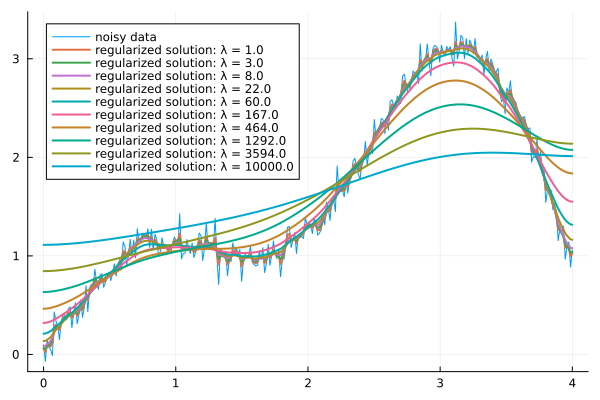

In [10]:
D = finiteDiff(n)
b̂ = [b; zeros(n-1)]
p = plot(t, b, w=1, leg =:topleft, label="noisy data")
for λ in LogRange(1e0, 1e4, 10) 
    Â = [ I; √λ*D ]
    xLS = Â \ b̂
    plot!(p, t, xLS, w=2, label="regularized solution: λ = $(round(λ))")
end
display(p)

> **Uniform scaling matrix**
>
> Note that the expression `Â = [ I; √λ*D ]` contains the
> [UniformScaling](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.UniformScaling-Tuple%7BInteger%7D)
> object `I` from the LinearAlgebra package. It represents an identity
> matrix of any size, i.e., `I` is a shorthand for `UniformScaling(1)`:
>
> ``` julia
> I == UniformScaling(1)
> @show rand(2)*I
> @show rand(3)*I;
> ```
>
>     rand(2) * I = [0.9780697196764138; 0.8532418055972256;;]
>     rand(3) * I = [0.7060651915306733; 0.4421385690004729; 0.8845770382856051;;]

## Equivalent constrained formulations

The formulation given in
<a href="#eq-lagrangian" class="quarto-xref">Equation 4</a> is an
example of an additive *penalty* method, where the functions $f_1$ and
$f_2$ are added together with balancing penalty parameter $\lambda$. But
there are other equally valid formulations that yield the same Pareto
optimal solutions. For example, here are three related formulations:

$$
\begin{aligned}
\min_x\,&\{f_1(x) + \lambda f_2(x)\,\}\\
\min_x\,&\{f_1(x)\mid f_2(x) \leq τ\} \\
\min_x\,&\{f_2(x)\mid f_1(x) \leq \sigma\}
\end{aligned}
$$

In the first formulation, the penalty parameter $\lambda$ controls the
tradeoff between the two objectives. The second and third formulations
are *constrained*, and the parameters $\tau$ and $\sigma$ directly
control the size of $f_2(x)$ and $f_1(x)$, respectively. Each
formulation has its place in the context of an application, and the
choice of formulation is often a matter of convenience.

The figure below shows the
result the three formulations for a small instance of Tikhonov-type
regularization, where $f_1(x)=\|Ax-b\|^2$ and $f_2(x)=\|x\|^2$. Each
requires a different choice of penalty parameter $\lambda$, $\tau$, or
$\sigma$ to achieve the same solution, but the shape of the Pareto
frontier is the same for all three formulations.

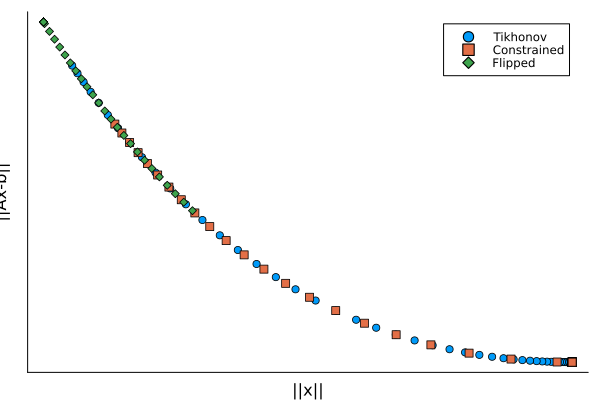

In [11]:
# Generate a small random overdetermined system
Random.seed!(123)
m, n = 9, 3
A = randn(m, n)
b = randn(m)

# Solve min ||Ax-b||^2 + λ||x||^2
function solveTikhonov(A, b, λ)
    x = Variable(n)
    problem = minimize(sumsquares(A*x - b) + λ*sumsquares(x))
    solve!(problem, ()->ECOS.Optimizer(), silent=true)
    x = evaluate(x)
    return norm(A*x-b), norm(x) 
end

# Solve min ||Ax-b||^2 s.t. ||x||^2 ≤ τ
function solveConstrained(A, b, τ)
    x = Variable(n)
    problem = minimize(sumsquares(A*x - b), sumsquares(x)≤τ)
    solve!(problem, ()->ECOS.Optimizer(), silent=true)
    x = evaluate(x)
    return norm(A*x-b), norm(x) 
end

# Solve min ||x||^2 s.t. ||Ax-b||^2 ≤ σ
function solveFlipped(A, b, σ)
    x = Variable(n)
    p = minimize(sumsquares(x), sumsquares(A*x - b) ≤ σ)
    solve!(p, ()->ECOS.Optimizer(), silent=true)
    x = evaluate(x)
    return norm(A*x-b), norm(x)
end

# Plot ||x|| vs. ||Ax-b|| for various values of λ, τ, and σ
prange = LogRange(1e-2, 1e2, 50)
p1 = map(λ -> solveTikhonov(A, b, λ), prange)
p2 = map(τ -> solveConstrained(A, b, τ), prange)
p3 = map(σ -> solveFlipped(A, b, σ), range(7e-0, 1e1, 50))
p = plot(xlabel="||x||", ylabel="||Ax-b||", ticks=false)
scatter!(p, [pair[2] for pair in p1], [pair[1] for pair in p1], label="Tikhonov", mark=:circle)
scatter!(p, [pair[2] for pair in p2], [pair[1] for pair in p2], label="Constrained", mark=:square)
scatter!(p, [pair[2] for pair in p3], [pair[1] for pair in p3], label="Flipped", mark=:diamond)